In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cam_pred = torch.tensor([
    [[ 5.9109e-01, -3.2541e-01, -4.3147e-01,  0.0000e+00],
     [-6.9326e-01,  3.2201e-01, -8.5394e-01,  0.0000e+00],
     [ 4.1232e-01,  4.1586e-02, -2.9089e-01,  5.0765e+03]],

    [[ 9.1732e-01, -1.8135e-01,  5.7269e-01,  0.0000e+00],
     [ 2.8530e-01,  1.4344e+00,  4.3006e-02,  0.0000e+00],
     [-2.7773e-01, -4.0118e-02, -8.1864e-01,  6.8301e+03]],

    [[-4.8849e-01, -7.3431e-01,  4.9769e-02,  0.0000e+00],
     [ 8.6995e-01, -2.1382e-01, -9.9753e-01,  0.0000e+00],
     [-6.7622e-02,  4.1833e-01, -4.9589e-02,  6.0136e+03]]
]).float()
cam_gt = cam_pred.clone()
cam_gt[:, :, 3] *= 0.5  # rescale to have nearer cams

In [3]:
pred = torch.tensor([
    [   0.6098, -104.0263,   73.8128],
    [   1.4834,  -50.2084,   45.5501],
    [  -7.3480,   -6.5471,   -4.2552],
    [   2.7473,    9.7827,    8.6768],
    [  12.4171,  -48.7536,   40.8225],
    [  15.2595, -102.6494,   78.2045],
    [   0.0000,    0.0000,    0.0000],
    [ -10.4454,   27.0264,  -22.0826],
    [ -20.9858,   66.0758,  -35.2288],
    [ -32.3971,   94.6393,  -46.2170],
    [ -18.7583,  -10.6285,    8.4239],
    [ -20.0129,   13.3701,  -18.8548],
    [ -23.8067,   50.6331,  -38.4751],
    [ -14.4592,   60.5305,  -18.8434],
    [  -1.5211,   31.4341,    8.7144],
    [   6.3713,   12.6556,   33.9137],
    [ -25.4074,   81.1748,  -38.2347]
]).double()  # or random ...
gt = pred * 0.5  # nearer cams => must have smaller KPs

In [4]:
def build_intrinsics(translation=(0, 0), f=(1, 1), shear=1):
    return np.array([
        [f[0], shear / f[0], translation[0]],
        [0   , f[1]        , translation[1]],
        [0.  , 0.          , 1.            ]
    ])


K = torch.tensor(
    build_intrinsics(
        translation=(0, 0),
        f=(1e2, 1e2),
        shear=0
    )  # same for all
).clone()

In [5]:
from viz import get_joints_connections, is_vip


def draw_kps_in_2d(axis, keypoints_2d, label, marker='o', color='blue'):
    for _, joint_pair in enumerate(get_joints_connections()):
        joints = [
            keypoints_2d[joint_pair[0]],
            keypoints_2d[joint_pair[1]]
        ]
        xs = joints[0][0], joints[1][0]
        ys = joints[0][1], joints[1][1]

        axis.plot(
            xs, ys,
            marker=marker,
            markersize=0 if label else 10,
            color=color,
        )

    if label:
        xs = keypoints_2d[:, 0]
        ys = keypoints_2d[:, 1]
        n_points = keypoints_2d.shape[0]

        cmap = plt.get_cmap('jet')
        colors = cmap(np.linspace(0, 1, n_points))
        for point_i in range(n_points):
            if is_vip(point_i):
                marker, s = 'x', 100
            else:
                marker, s = 'o', 10
            axis.scatter(
                [ xs[point_i] ], [ ys[point_i] ],
                marker=marker,
                s=s,
                color=colors[point_i],
                label=label + ' {:.0f}'.format(point_i)
            )

In [6]:
def euclidean_to_homogeneous(points):
    """ [x y z] -> [x y z 1] """

    return torch.cat([
        points,
        torch.ones(
            (points.shape[0], 1), dtype=points.dtype, device=points.device
        )
    ], dim=1)


def homogeneous_to_euclidean(points):
    """ [x y z w] -> [x/w y/w z/w] """
    
    return (points.transpose(1, 0)[:-1] / points.transpose(1, 0)[-1]).transpose(1, 0)


def world2proj(K, ext):
    projection = torch.mm(
        K.double(),
        ext.double()
    ).T
    
    def _f(x):
        homo = euclidean_to_homogeneous(x)
        return homogeneous_to_euclidean(homo @ projection)
    
    return _f
    

def compare_in_proj(axis, cam_i):
    def _plot(cam, kps, label, color):
        in_proj = world2proj(K, cam)(kps.detach().cpu())
        draw_kps_in_2d(axis, in_proj.cpu().numpy(), label=label, color=color)

    _plot(cam_gt[cam_i], gt, 'gt', 'blue')
    _plot(cam_pred[cam_i], pred, 'pred', 'red')

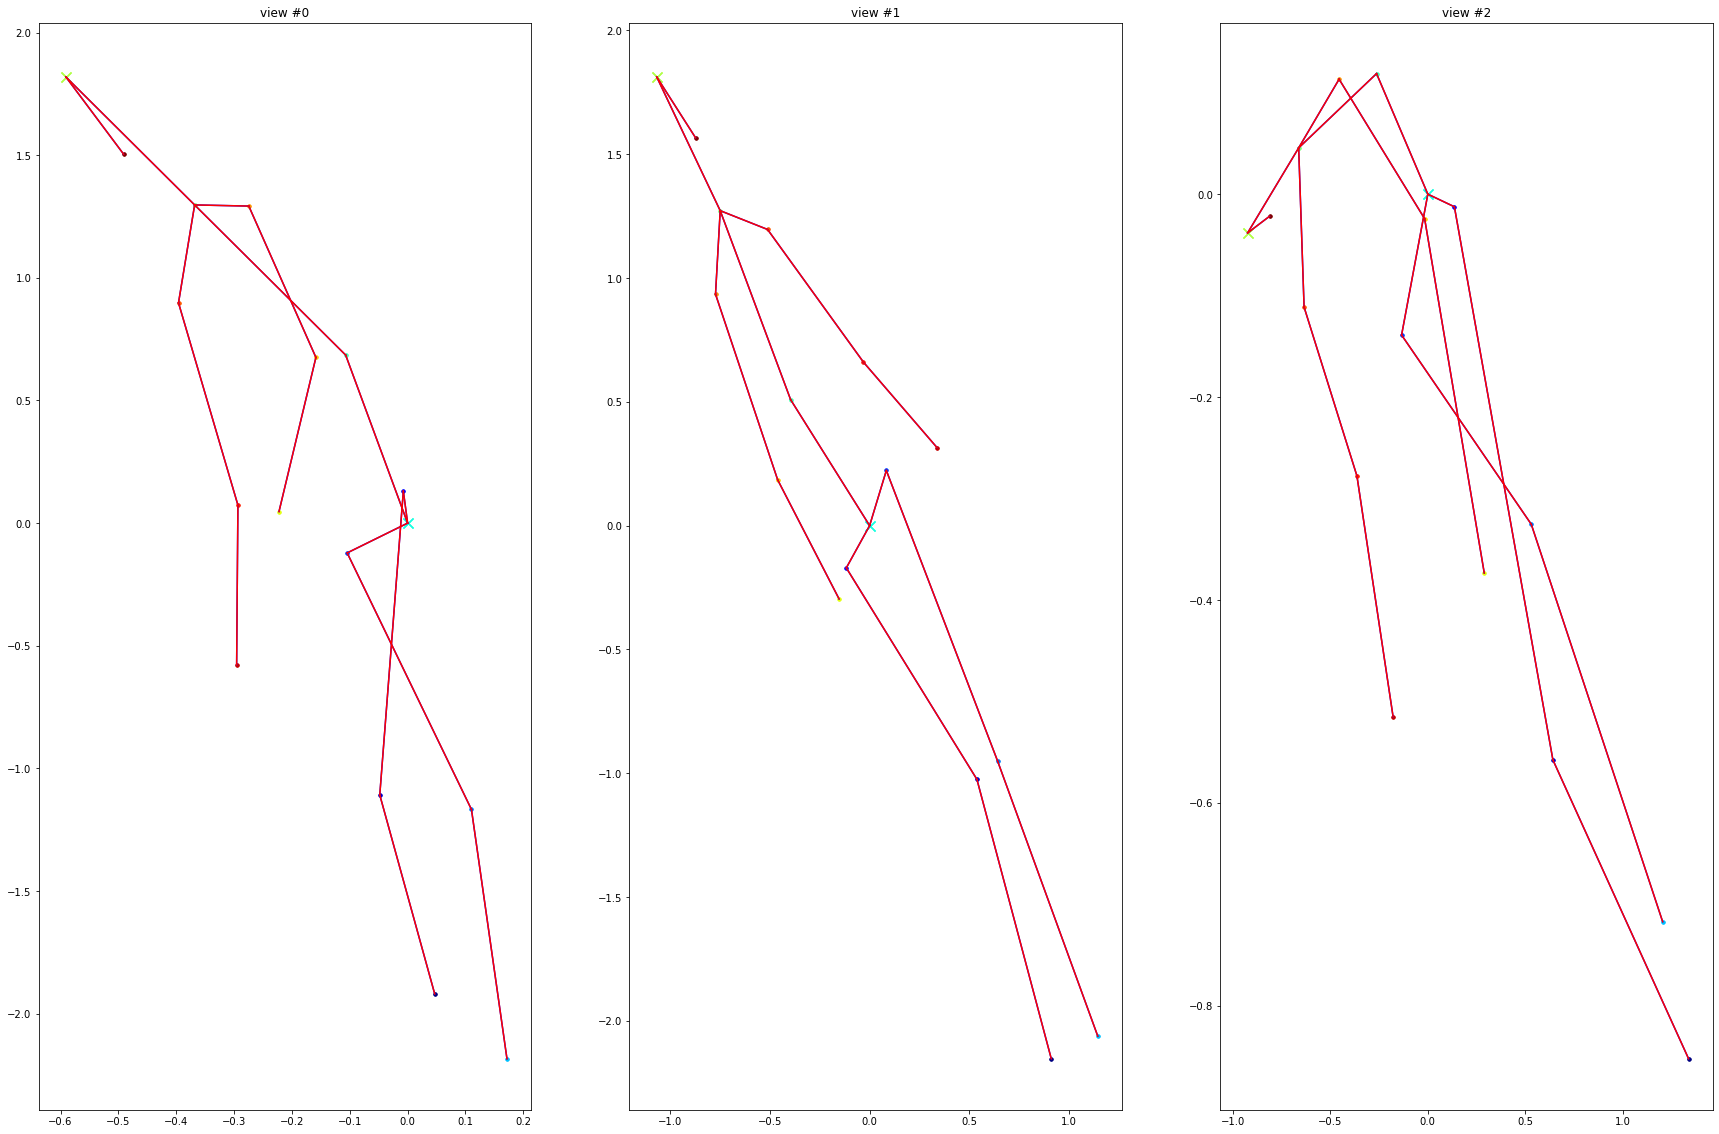

In [7]:
n_views = cam_pred.shape[0]
fig = plt.figure(figsize=(30, 20))

for view_i in range(n_views):
    axis = fig.add_subplot(1, n_views, view_i + 1)
    compare_in_proj(axis, cam_i=view_i)
    
    axis.set_title('view #{:.0f}'.format(view_i))